# 2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

# データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

In [1]:
#import
import pandas as pd
import numpy as np
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette="bright")
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

Using TensorFlow backend.


# 画像データから配列に変換する関数

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

# 配列から画像データに変換する関数

In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

## $$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$



$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。


## $$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpool_ha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpool_ha \frac{\partial L}{\partial b_{m}}
$$

$\alpool_ha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。


## $$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

## $$ 
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。



In [3]:
class Conv2d:
    """
    1次元畳み込み層クラス（padding=0,stride=1）
    """
    def __init__(self, W, b, stride=1, pad=0,lr=0.01 ):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.lr = lr
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        順伝播
        -----------------------
        x (numpy.ndarray): 入力 shape(N, C, H, W)
        
        out(numpy.ndarray):出力shape(N, FN, out_h, out_w)
        """
        #フィルター数、チャネル数、フィルターの高さ、フィルターの幅を重みのshapeをもとに作成
        FN, C, FH, FW = self.W.shape#FN:フィルター数、C:チャンネル数、FH:フィルターの高さ、FW:幅
        
        #入力、チャネル数（チャネル数はフィルターと入力同じ数）、入力の高さ、入力の幅を入力データをもとに作成
        N, C, H, W = x.shape#N:バッチサイズ、x_C:チャンネル数、H：入力データの高さ、W:幅
        
        #出力される特徴マップの高さ・幅を算出
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        #画像からユニットを取り出して列として並べる
        # (N, C, H, W) → (N * out_h * out_w, C * FH * FW)
        col = im2col(x, FH, FW, self.stride, self.pad)
        
        #フィルターにも同様の処理を
        # (FN, C, FH, FW) → (C * FH * FW, FN)
        col_W = self.W.reshape(FN, -1).T
        
        #入力と重みをかけてバイアスを足す
        #(N * out_h * out_w, C * FH * FW)・(C * FH * FW, FN) → (N * out_h * out_w, FN)
        out = np.dot(col, col_W) + self.b
        
        #計算しやすいように入れ替える
        # (N * out_h * out_w, FN) → (N, out_h, out_w, FN) → (N, FN, out_h, out_w)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        #逆伝播の時に使うため保持する
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        """
        逆伝播
        """
        #フィルター数、チャネル数、フィルターの高さ、フィルターの幅を重みのshapeをもとに作成
        FN, C, FH, FW = self.W.shape
        #計算しやすいように入れ替える
        # (N, FN, out_h, out_w) → (N, out_h, out_w, FN) → (N * out_h * out_w, FN)
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        #出力の勾配を列方向に足し合わせる
        self.db = np.sum(dout, axis=0)# → (FN)
        
        #順伝播時にim2col変換したものと出力の勾配の行列積を算出する
        self.dW = np.dot(self.col.T, dout)# → (C * FH * FW, FN)
        
        #計算しやすいように入れ替える
        # (C * FH * FW, FN) → (FN, C * FH * FW) → (FN, C, FH, FW)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        #出力の勾配とim2col変換をしたフィルターの行列積を求める
        dcol = np.dot(dout, self.col_W.T)# → (N * out_h * out_w, C * FH * FW)
        
        #画像形式に戻す（col2im変換）
        # (N * out_h * out_w, C * FH * FW) → (N, C, H, W)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        # 逆伝播して求めた勾配でパラメータを更新
        self.update()
        return dx
    
    def update(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

## $$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

In [4]:
def out_size(H, W, P, FH, FW, S):
    out_h = (H + 2 * P - FH) / S + 1
    out_w = (W + 2 * P - FW) / S + 1
    return int(out_h), int(out_w)

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

## $$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$


$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）


$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス


$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [5]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        """Poolingレイヤー
        --------------------------------------------------------
            pool_h  プーリング領域の高さ
            pool_w : プーリング領域の幅
            stride : ストライド、デフォルトは1
            pad : パディング、デフォルトは0
        """
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None           # 逆伝播で必要になる、順伝播時の入力
        self.arg_max = None     # 逆伝播で必要になる、順伝播時に採用したcol_x各行の位置

    def forward(self, x):
        """順伝播
        --------------------------
            x (numpy.ndarray): 入力、形状は(N, C, H, W)
            
            out(numpy.ndarray): 出力、形状は(N, C, out_h, out_w)
        """
        N, C, H, W = x.shape  # N:データ数、C:チャンネル数、H:高さ、W:幅
        
        #出力サイズを計算
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 入力データを展開、整形
        # (N, C, H, W) → (N * out_h * out_w, C * pool_h * pool_w)
        col_x = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # (N * out_h * out_w, C * pool_h * pool_w) → (N * out_h * out_w * C, pool_h * pool_w)
        col_x = col_x.reshape(-1, self.pool_h * self.pool_w)

        # 出力を算出
        # (N * out_h * out_w * C, pool_h * pool_w) → (N * out_h * out_w * C)
        out = np.max(col_x, axis=1)

        # 結果の整形
        # (N * out_h * out_w * C) → (N, out_h, out_w, C) → (N, C, out_h, out_w)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        # 逆伝播のために保存
        self.x = x
        self.arg_max = np.argmax(col_x, axis=1)  # col_x各行の最大値の位置（インデックス）

        return out

    def backward(self, dout):
        """逆伝播
        -------------------------------
            dout (numpy.ndarray): 右の層から伝わってくる微分値、形状は(N, C, out_h, out_w)

            dx(numpy.ndarray): 微分値（勾配）、形状は(N, C, H, W)
        """
        # 右の層からの微分値を整形
        # (N, C, out_h, out_w) → (N, out_h, out_w, C)
        dout = dout.transpose(0, 2, 3, 1)

        # 結果の微分値用のcolを0で初期化
        # (N * out_h * out_w * C, pool_h * pool_w)
        pool_size = self.pool_h * self.pool_w
        
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        
         # 結果の微分値の整形
        # (N * out_h * out_w * C, pool_h * pool_w) → (N, out_h, out_w, C, pool_h * pool_w)
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        # 結果の微分値の整形
        # (N, out_h, out_w, C, pool_h * pool_w) → (N * out_h * out_w, C * pool_h * pool_w)
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        
        # 結果の微分値の整形
        # (N * out_h * out_w, C * pool_h * pool_w) → (N, C, H, W)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [6]:
class Flatten:
    """
    平滑化
    -----------------------
    forward時はチャンネル、高さ、幅の3次元を1次元に
    backward時は元の入力の形状に
    """
    def forward(self, x):
        #入力サイズ、チャネル数、入力の高さ、幅を入力の形状に
        N, C, H, W = x.shape
        #平滑化
        flatten = x.reshape(N, -1)
        #逆伝播で入力と同じ形状にするため入力を保持
        self.x = x
        
        return flatten

# 3.検証

# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

## ミニバッチを取得するクラス

In [ ]:

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    


## 全結合層

In [ ]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        
        #初期化手法
        self.initializer = initializer
        
        #最適化手法
        self.optimizer = optimizer
        
        # 指定したinitializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
        
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        #フォワード時の入力Xをインスタンス変数として保持
        self.X = X
        
        #順伝播
        self.A = self.X@self.W + self.B
        
        return self.A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 逆伝播
        self.dB = np.sum(dA,axis=0)#dA・・・逆伝播する際に活性化関数に通して出力された値
        self.dW = self.X.T@dA
        self.dZ = dA@self.W.T
        
        #インスタンスの重みとバイアス自身を指定した最適手法により求めた値で更新
        self = self.optimizer.update(self)
        
        return self.dZ
    
    

## 初期化手法
### ガウス分布によるシンプルな初期化手法

In [ ]:

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :　重みの初期値
        """
        W = self.sigma*np.random.randn(n_nodes1,n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :バイアスの初期値
        """
        B = self.sigma*np.random.randn(1,n_nodes2)
        return B

    
    
    

## 最適化手法
### 最適化手法（SGD）

In [ ]:
class SGD():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
       
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #パラメータを誤差逆伝播で算出したものに学習率をかけて更新
        layer.W -= self.lr*layer.dW/20#バッチサイズで割る
        layer.B -= self.lr*layer.dB/20
        
        #パラメータを更新したインスタンスを返す
        return layer
  

## 活性化関数
### ハイパボリックタンジェント

In [ ]:
class Tanh:
    '''
    ハイパボリックタンジェント関数
    '''
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            出力
        """ 
        self.A = A
        Z = np.tanh(self.A)
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = dZ * (1 - np.tanh(self.A)**2)
        return dA

        

### ソフトマックス関数

In [7]:

 

class Softmax:
        """
        Parameters
        ----------
        A : 各層に入力される値(batch_size, n_nodes_1)
        dZ : バックワード時に前に流す勾配(batch_size, n_nodes1)

       Returns
        -------
        Z : 各層からの出力される値(batch_size, n_nodes1)
        dA : バックワード時に後ろから流れてきた勾配(batch_size, n_nodes2)
        """
        def forward(self,A):
            Z = np.exp(A)/np.sum(np.exp(A),axis=1).reshape(-1,1)
            
            return Z
         
        def backward(self,A,y):
            dA = self.forward(A) - y
            #back時は交差エントロピー誤差も計算
            L = - np.sum(y * np.log(self.forward(A))) / len(y)
            
            return dA,L        

## 2次元のCNNクラス

In [23]:
class Conv2d_NN():
    """
    2次元の畳み込み層を加えたニューラルネットワーク分類器
    Parameters
    ----------
    """
    def __init__(self,FN=30,FH=3,FW=3,stride=1,pad=0, epoch=10,batch_size=20,sigma=0.1,lr=0.01,verbose=False):
        
        #パラメータ
        self.epoch = epoch 
        self.batch_size =  batch_size
        self.sigma = sigma 
        self.lr = lr 
        self.verbose = verbose
        
        #全結合層で使用
        self.optimizer = SGD
        self.initializer = SimpleInitializer
        self.activater = Tanh()
        self.softmax = Softmax()
        self.flatten = Flatten()
        
        #畳み込み層で使用
        self.FN = FN#フィルターの数
        self.C = 1#チャネル数
        self.FH = FH#フィルターの縦の大きさ
        self.FW = FW#フィルターの幅
        self.pad = pad#padding
        self.stride = stride#ストライド 
        self.n_output = 10 #出力数
        
        #pooling層クラス呼び出しのためにプーリング フィルターのサイズを指定
        self.pool_h = 1 # プーリングフィルターの高さ
        self.pool_w = 1 # プーリングフィルターの幅
        #pooling層クラスを呼び出し
        self.max_pool = MaxPool2D(self.pool_h, self.pool_w)
        
        # 畳み込み層クラス呼び出しのために、重みとバイアスの初期値を生成
        self.w = self.sigma * np.random.randn(self.FN, self.C, self.FH, self.FW)
        self.b = self.sigma * np.random.randn(self.FN,)
        #畳み込みクラスを呼び出し
        self.conv = Conv2d(self.w,self.b)

        # 全結合層クラスを呼び出すために、全結合層への入力を計算する
        #畳み込み層からプーリング 層
        out_h, out_w = self.out_size(28,28, self.pad, self.FH, self.FW, self.stride)
        
        #プーリング 層から全結合層
        out_h, out_w = self.out_size(out_h, out_w, 0, self.pool_h, self.pool_w, self.pool_h)
        
        #全結合層への入力を計算
        node_n = self.FN * out_h * out_w
        
        #全結合層クラスを呼び出し
        self.FC = FC(node_n, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr))
        
        #グラフ描画用にlossを保存するリスト
        self.loss_train = []
        self.loss_val = []

    #畳み込み層からの出力サイズを計算    
    def out_size(self,H, W, P, FH, FW, S):
        out_h = (H + 2 * P - FH) / S + 1
        out_w = (W + 2 * P - FW) / S + 1
        return int(out_h), int(out_w)#float➡︎int

    #学習
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """  
        #バッチごとに計算
        for epoch in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=epoch)
            #エポックごとにlossを初期化
            loss = 0
            val_loss = 0
            #エポックごとにイテレーション数を初期化
            iter_num = 0
            
            for mini_X, mini_y in get_mini_batch:
                # フォワード
                A1 = self.conv.forward(mini_X)
                Z1 = self.activater.forward(A1)
                P1 = self.max_pool.forward(Z1)
                F1 = self.flatten.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.softmax.forward(A2)

                # バックワード
                dA2, loss = self.softmax.backward(Z2, mini_y)
                dZ2 = self.FC.backward(dA2)
                dF1 = self.flatten.backward(dZ2)
                dP1 = self.max_pool.forward(dF1)
                dA1 = self.activater.backward(dP1)
                dZ1 = self.conv.backward(dA1)
            
                # 求めたパラメータで再度通る
                A1 = self.conv.forward(X)
                Z1 = self.activater.forward(A1)
                P1 = self.max_pool.forward(Z1)
                F1 = self.flatten.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.softmax.forward(A2)
                
                 # iイテレーションごとに交差エントロピーを計算
                loss += self.softmax.backward(Z2, y)[1]
                
                #エポックの平均を出すためにイテレーション数を記録
                iter_num+=1
                
                #valデータが入力されたら順伝播＆softmax.backwardで交差エントロピー誤差を算出
                if X_val is not None:
                    A1 = self.conv.forward(X_val)
                    Z1 = self.activater.forward(A1)
                    P1 = self.max_pool.forward(Z1)
                    F1 = self.flatten.forward(P1)
                    A2 = self.FC.forward(F1)
                    Z2 = self.softmax.forward(A2)         
                    val_loss += self.softmax.backward(Z2, y_val)[1]
                    
            #エポックごとのlossの平均を算出、リストに格納
            ave_loss = loss/iter_num
            ave_val_loss = val_loss/iter_num
            self.loss_train.append(ave_loss)
            self.loss_val.append(ave_val_loss)
            
            if self.verbose:
                #verboseをTrueにした際は各エポックごとの損失の平均を出力する
                print("Epoch{}".format(epoch))
                print("loss:{:.10f}/val_loss:{:.10f}".format(ave_loss,ave_val_loss))

    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #学習したパラメータで畳み込み層から全部通る
        A1 = self.conv.forward(X)
        Z1 = self.activater.forward(A1)
        P1 = self.max_pool.forward(Z1)
        F1 = self.flatten.forward(P1)
        A2 = self.FC.forward(F1)
        Z2 = self.softmax.forward(A2)
        #sofmaxを通した最後の層で確率が一番高いものを推定結果とする
        return np.argmax(Z2, axis=1)

In [24]:
# データセット読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# # チャネル数の軸を追加
X_train = X_train[:,None]
X_test = X_test[:,None]

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


# ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])


In [27]:
C2NN =  Conv2d_NN(
    FN=20,
    FH=5,
    FW=5,
    stride=1,
    pad=0, 
    epoch=10,
    batch_size=20,
    sigma=0.1,
    lr=0.01,
    verbose=True
)

C2NN.fit(X_train[:100], y_train_one_hot[:100], X_val[:50], y_test_one_hot[:50])
pred = C2NN.predict(X_val)
accuracy_score(y_val, pred)

Epoch0
loss:0.8235570143/val_loss:2.2116118726
Epoch1
loss:0.7866961751/val_loss:1.9787450265
Epoch2
loss:0.7008518148/val_loss:1.8989777366
Epoch3
loss:0.6871410808/val_loss:1.8610385125
Epoch4
loss:0.6573725843/val_loss:1.8428555425
Epoch5
loss:0.6699137162/val_loss:1.8478033122
Epoch6
loss:0.6890916606/val_loss:1.8276997300
Epoch7
loss:0.6798342042/val_loss:1.8381619397
Epoch8
loss:0.6539848767/val_loss:1.8225934345
Epoch9
loss:0.6934500247/val_loss:1.8198000870


0.6235833333333334

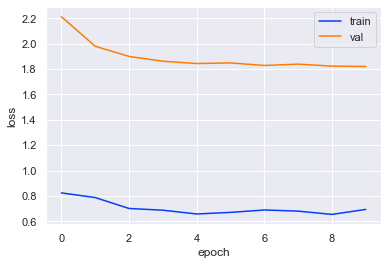

In [28]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(C2NN.loss_train, label='train')
plt.plot(C2NN.loss_val, label='val')
plt.legend()

# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.


入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

2.


入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3.


入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [34]:
def out_size(H, W, P, FH, FW, S):
    """
    出力のサイズを計算する関数
    """
    out_h = (H + 2 * P - FH) / S + 1
    out_w = (W + 2 * P - FW) / S + 1
    
    return int(out_h), int(out_w)


def cul_param(in_C,FW,FH,f_C):
    """
    パラメータの数を計算する関数
    入力サイズのチャンネル数×フィルターの横×フィルターの縦×フィルターサイズチャンネル数+フィルターサイズチャンネル数
    """
    return in_C*FW*FH*f_C+f_C

In [35]:
# 1.入力サイズ : 144×144, 3チャンネル フィルタサイズ : 3×3, 6チャンネル ストライド : 1 パディング : なし

print("出力サイズ：{}".format(out_size(144,144,0,3,3,1)))
print("パラメータ数：{}".format(cul_param(3,3,3,6)))

出力サイズ：(142, 142)
パラメータ数：168


In [36]:
#2入力サイズ : 60×60, 24チャンネル フィルタサイズ : 3×3, 48チャンネル ストライド　: 1 パディング : なし

print("出力サイズ：{}".format(out_size(60, 60, 0, 3, 3, 1)))
print("パラメータ数：{}".format(cul_param(3, 3, 24, 48)))

出力サイズ：(58, 58)
パラメータ数：10416


In [37]:
#3.入力サイズ : 20×20, 10チャンネル フィルタサイズ: 3×3, 20チャンネル ストライド : 2 パディング : なし

print("出力サイズ：{}".format(out_size(20, 20, 0, 3, 3, 2)))
print("パラメータ数：{}".format(cul_param(3, 3, 10, 20)))

出力サイズ：(9, 9)
パラメータ数：1820
